<a href="https://colab.research.google.com/github/alex-jk/SWB-GVCEH/blob/main/models/relevance_model/Relevance_Model_Reddit_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
!pip install setfit
!pip install tqdm
!pip install -U sentence-transformers

In [61]:
import pandas as pd
import numpy as np
from setfit import SetFitModel
from tqdm.notebook import tqdm
from sentence_transformers import SentenceTransformer
import spacy
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

model_sent_transformer = SentenceTransformer('all-MiniLM-L6-v2')
# Load spaCy model for sentence tokenization
nlp = spacy.load("en_core_web_sm")

##### Import reddit datasets

In [62]:
file_path = '/content/drive/My Drive/SWB-GVCEH/VictoriaBC_data_updated.csv'
VictoriaBC_data_nodups = pd.read_csv(file_path)
VictoriaBC_data_nodups = VictoriaBC_data_nodups.drop_duplicates().reset_index(drop=True)

print("\nVictoria BC data ----------------")
print(VictoriaBC_data_nodups.shape)
print(VictoriaBC_data_nodups.columns)
print(VictoriaBC_data_nodups.head())

Sooke_data_nodups = pd.read_csv('/content/drive/My Drive/SWB-GVCEH/Sooke_data.csv')
Sooke_data_nodups = Sooke_data_nodups.drop_duplicates().reset_index(drop=True)

print("\nSooke data ----------------")
print(Sooke_data_nodups.shape)
print(Sooke_data_nodups.columns)
print(Sooke_data_nodups.head())


Victoria BC data ----------------
(8998, 6)
Index(['Subreddit', 'Title', 'Text', 'Submission ID', 'User ID',
       'Search Term'],
      dtype='object')
    Subreddit                                              Title  \
0  VictoriaBC  True change around homelessness from the homel...   
1  VictoriaBC  New transitional housing facility on Douglas o...   
2  VictoriaBC   Where to buy a reasonably priced Christmas tree?   
3  VictoriaBC  Looking for a Christmas tree? Please consider ...   
4  VictoriaBC                              Free clothing places?   

                                                Text Submission ID  \
0  I've started my own organization to expose the...        zen3ao   
1                                                NaN        5yah6z   
2  Went to the Christmas tree farm today and thou...       17yjdiw   
3                                                NaN        7h0e58   
4  Hey so long story short I moved here from Sask...       169ywlj   

          User 

In [63]:
file_url = 'https://drive.google.com/uc?id=1ANE3_UkNi2UGyQpHr8Ujz1QwBNKxmcTl'

# Reading the CSV file into a DataFrame
additional_reddit_df = pd.read_csv(file_url)
additional_reddit_df = additional_reddit_df.drop_duplicates().reset_index(drop=True)
additional_reddit_df.rename(columns={'Body': 'Text'}, inplace=True)

print("\nAdditional reddit data ----------------")
print(additional_reddit_df.shape)
print(additional_reddit_df.columns)
print(additional_reddit_df.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Additional reddit data ----------------
(2057, 4)
Index(['Subreddit', 'Title', 'Text', 'Comments'], dtype='object')
               Subreddit                                              Title  \
0  OakBayBritishColumbia                            Oak Bay high right now.   
1  OakBayBritishColumbia  Food share for Ukrainian refugees on Vancouver...   
2  OakBayBritishColumbia     Lost Budgie - Cadboro Bay (Willows Elementary)   
3  OakBayBritishColumbia  What are 3 things I must see when visiting Oak...   
4  OakBayBritishColumbia  Yes, this is a leaf blower rant, but hear me o...   

                                                Text  \
0  Anyone know what the hell is going on at Oak B...   
1                                                NaN   
2  My friends blue budgie flew out of the house l...   
3                                            Thanks!   
4  I have a neighbour who uses his leaf blower to...   

                                            Comments  
0  ['https://www

##### Combine all data into one df

In [81]:
# Combining the DataFrames
select_cols = ['Subreddit', 'Title', 'Text']
combined_df = pd.concat([VictoriaBC_data_nodups[select_cols], Sooke_data_nodups[select_cols], additional_reddit_df[select_cols]], ignore_index=True)

# Resetting the index
combined_df.reset_index(drop=True, inplace=True)

combined_df['TitleText'] = combined_df['Title'].fillna('') + '. ' + combined_df['Text'].fillna('')

nan_titletext_df = combined_df[combined_df['TitleText'].isna()]
# Resetting the index
nan_titletext_df.reset_index(drop=True, inplace=True)

# Remove rows where 'TitleText' is NaN
combined_df.dropna(subset=['TitleText'], inplace=True)
# Resetting the index again after dropping rows
combined_df.reset_index(drop=True, inplace=True)

print("\nCombined data ----------------")
print(combined_df.shape)
print(combined_df.columns)
print(combined_df.head())


Combined data ----------------
(11160, 4)
Index(['Subreddit', 'Title', 'Text', 'TitleText'], dtype='object')
    Subreddit                                              Title  \
0  VictoriaBC  True change around homelessness from the homel...   
1  VictoriaBC  New transitional housing facility on Douglas o...   
2  VictoriaBC   Where to buy a reasonably priced Christmas tree?   
3  VictoriaBC  Looking for a Christmas tree? Please consider ...   
4  VictoriaBC                              Free clothing places?   

                                                Text  \
0  I've started my own organization to expose the...   
1                                                NaN   
2  Went to the Christmas tree farm today and thou...   
3                                                NaN   
4  Hey so long story short I moved here from Sask...   

                                           TitleText  
0  True change around homelessness from the homel...  
1  New transitional housing facili

In [65]:
ind = 0
print(nan_titletext_df.iloc[ind])

Subreddit                                           VictoriaBC
Title        New transitional housing facility on Douglas o...
Text                                                       NaN
TitleText                                                  NaN
Name: 0, dtype: object


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


##### Load twitter data

In [66]:
# List of file names
file_names = [
    'GVCEH-tweets-combined_2023-02-08.csv',
    'GVCEH-tweets-combined_2023-01-30.csv',
    'GVCEH-tweets-combined_2023-01-21.csv',
    'GVCEH-tweets-combined_2023-01-12.csv'
]

# Base URL for raw files in the GitHub repository
base_url = 'https://raw.githubusercontent.com/alex-jk/SWB-GVCEH/main/data/processed/twitter/github_actions/'

# Initialize a list to collect the DataFrames
dfs = []

for file_name in file_names:
    # Construct the full URL for the current file
    file_url = base_url + file_name
    # Read the CSV file
    current_df = pd.read_csv(file_url)
    # Append the DataFrame to the list
    dfs.append(current_df)

# Concatenate all DataFrames in the list
tweets_combined_df = pd.concat(dfs, ignore_index=True)
# Remove duplicates
tweets_combined_df = tweets_combined_df.drop_duplicates().reset_index(drop=True)

# Displaying the first few rows of the DataFrame
print(tweets_combined_df.shape)
print(tweets_combined_df.columns)
print(tweets_combined_df.head())

(5435, 17)
Index(['Unnamed: 0', 'text', 'scrape_time', 'tweet_id', 'created_at',
       'reply_count', 'quote_count', 'like_count', 'retweet_count',
       'geo_full_name', 'geo_id', 'username', 'num_followers',
       'search_keywords', 'search_neighbourhood', 'sentiment', 'score'],
      dtype='object')
   Unnamed: 0                                               text  \
0           0  RT pressjournal: Colonsay islanders and people...   
1           1  Colonsay islanders and people who have left th...   
2           7  @ArianeBurgessHI Serviced plots for 25k are ex...   
3           9  RT @VicBuilders: "25-unit townhome development...   
4          27  @OurNewHomecoach @laughatthemoon2 There is so ...   

                  scrape_time             tweet_id                 created_at  \
0  2023-02-07 03:20:43.040309  1622564995115503616  2023-02-06 11:56:55+00:00   
1  2023-02-07 03:20:43.040317  1622550741599625221  2023-02-06 11:00:16+00:00   
2  2023-02-07 03:20:51.207543  1622549961

##### Check twitter data

In [67]:
ind = 8
print(tweets_combined_df['search_neighbourhood'][ind])
print(tweets_combined_df['search_keywords'][ind])
print(tweets_combined_df['text'][ind])

burnside-gorge OR fairfield-gonzales OR hollywood park OR north park OR pauquachin OR salt spring island OR stadacona park OR victoria
(burnside-gorge OR fairfield-gonzales OR hollywood park OR north park OR pauquachin OR salt spring island OR stadacona park OR victoria) (anawin companion society OR safer victoria OR vtag OR mental health recovery partners, south island OR vancouver island mental health society OR greater victoria acting together OR the mustard seed OR yyj tenants union OR pacifica housing OR solid outreach OR housing OR camper) lang:en -is:retweet
Can you trust @Dave_Eby?One week he says he's not buying in Burnside GorgeThen they announce he (as Housing Minister) "bought a hotel (Capital City Centee) adjacent to Downtown"Adjacent = Burnside Gorge@Adam_Stirling, what do you think?Can Eby be trusted? https://t.co/6yYCcXAvvC @mattdellok @Stephen_Andrew @BC_Housing @Dave_Eby @VictoriaDRA "It would be easier to buy in Burnside Gorge" Minister Eby https://t.co/bSP0LdgPwJ


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [68]:
# Load the pretrained SetFit model
model = SetFitModel.from_pretrained("sheilaflood/gvceh-setfit-rel-model2")

# Example text data
texts = ["Example text relevant to homelessness in Victoria.", "Irrelevant text about other topics."]

# Model makes predictions
predictions = model(texts)
print(predictions)

tensor([1, 0])


In [69]:
ind = 7
model(tweets_combined_df['text'][ind])

tensor(1)

##### Check that tweets are considered relevant by the model
- all tweets were found to be relevant by the model

In [70]:
# Define a function to make predictions
def get_prediction(text):
    prediction = model([text])[0]
    return prediction

# # Apply the model to each row in the 'text' column with a progress bar
# tqdm.pandas()  # Enable tqdm for pandas
# tweets_combined_df['relevant'] = tweets_combined_df['text'].progress_apply(get_prediction)

In [71]:
def extract_integer_from_tensor(tensor_val):
    return tensor_val.item()

# Apply this function to the entire column
# tweets_combined_df['relevant'] = tweets_combined_df['relevant'].apply(extract_integer_from_tensor)

# Print value counts for the 'relevant' column
# print(tweets_combined_df['relevant'].value_counts())

##### Perform K-Means clustering of twitter data
Generate embeddings of twitter posts

In [72]:
twitter_embeddings = model_sent_transformer.encode(tweets_combined_df['text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/170 [00:00<?, ?it/s]

##### Run K-Means on twitter embeddings

Current k: 1
Current k: 2
Current k: 3
Current k: 4
Current k: 5
Current k: 6
Current k: 7
Current k: 8
Current k: 9
Current k: 10
Current k: 11
Current k: 12
Current k: 13
Current k: 14
Current k: 15
Current k: 16
Current k: 17
Current k: 18
Current k: 19
Current k: 20
Current k: 21
Current k: 22
Current k: 23
Current k: 24
Current k: 25
Current k: 26
Current k: 27
Current k: 28
Current k: 29
Current k: 30
Current k: 31
Current k: 32
Current k: 33
Current k: 34
Current k: 35
Current k: 36
Current k: 37
Current k: 38
Current k: 39


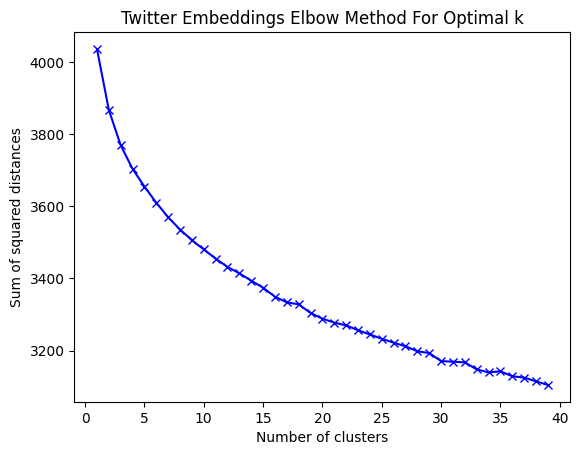

In [73]:
# Calculate sum of squared distances for different number of clusters
Sum_of_squared_distances = []
K = range(1,40)  # Adjust the range based on your dataset
for k in K:
    print(f"Current k: {k}")
    km = KMeans(n_clusters=k, n_init=10)
    km = km.fit(twitter_embeddings)
    Sum_of_squared_distances.append(km.inertia_)

# Plot the elbow graph
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Twitter Embeddings Elbow Method For Optimal k')
plt.show()

#####Assign clusters to embeddings

In [74]:
from sklearn.cluster import KMeans

k = 15  # number of clusters
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
kmeans.fit(twitter_embeddings)

cluster_centroids = kmeans.cluster_centers_

tweets_combined_df['cluster'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
print(tweets_combined_df['cluster'].unique())

ind = 2
cluster_tweets = tweets_combined_df[tweets_combined_df['cluster'] == ind].copy().reset_index(drop=True)
for i in range(0, 10):
  print("\n---------------------Printing tweet")
  print(cluster_tweets['text'][i])

[ 4  5 14 13 12 10  6  9  1 11  0  2  8  3  7]

---------------------Printing tweet
Victoria has some of the lowest rates of funding for public schools in the country... and for public hospitals... and for public housing. 
Notice a trend? https://t.co/4MiGBB31Xo

---------------------Printing tweet
@ianincolwood @JohnsonStBRDG I do kinda think we Victoria people are kinda throwing stones from glass houses. Calgary does build a lot of housing and the trajectory for mass transit is looking good, which I can't say applies to us.

---------------------Printing tweet
@DumbLayman @BirthGauge City of Vancouver and Victoria are fairly similar to their CMA surprisingly (although variations by neighbourhoods).

---------------------Printing tweet
@CityOfVictoria Victoria has a very left wing, anti small business City Council, so be very careful if you’re planning on opening a business here. For example, they underfund the police so crime and beak ins are out of control…

---------------------Pri

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
# Function to split text into sentences
def spacy_sentence_split(text):
    doc = nlp(text)
    return [sent.text.strip() for sent in doc.sents]

import concurrent.futures

# Function to process a single Reddit post and determine its relevance
def process_post_for_relevance(post, model, centroids, threshold):
    sentences = spacy_sentence_split(post)
    sentence_embeddings = model.encode(sentences, show_progress_bar=False)
    sentence_relevance_scores = cosine_similarity(sentence_embeddings, centroids)
    max_scores = sentence_relevance_scores.max(axis=1)
    relevant_sentences = max_scores > threshold
    relevance_score = relevant_sentences.mean()  # Proportion of sentences above the threshold
    return relevance_score

# Parallel processing function
def parallel_relevance_computation(reddit_posts, model, centroids, threshold, max_workers=10):
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        relevance_scores = list(tqdm(executor.map(lambda post: process_post_for_relevance(post, model, centroids, threshold), reddit_posts), total=len(reddit_posts)))
    return relevance_scores

In [90]:
print(combined_df.shape)
check_post = combined_df['TitleText'][11]

print(check_post)

process_post_for_relevance(check_post, model_sent_transformer, cluster_centroids, threshold=0.5)

(11160, 4)
Has BC Housing confirmed that for new supportive housing there will be no screening of prospective tenants for violent offenders and no restrictions on drug supply or use?. [I just read this article; a commentary by an anonymous Victoria councillor where they state that BC Housing confirmed that for new supportive housing there will be no screening of prospective tenants for violent offenders and no restrictions on drug supply or use.](https://www.timescolonist.com/opinion/comment-to-fix-what-ails-the-city-we-need-to-change-course-7342054)

This sounds like a shit fucking idea. I tried looking for a press release or something from BC Housing that can back this up but haven't found anything. 


0.75

In [ ]:
# Apply parallel relevance computation to the DataFrame
combined_df['relevance_score'] = parallel_relevance_computation(combined_df['TitleText'].tolist(), model_sent_transformer, cluster_centroids, threshold=0.5)

  0%|          | 0/11160 [00:00<?, ?it/s]